In [1]:
import os
import h5py

import socket
import struct
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import time

from tqdm import tqdm



import numpy as np
import copy

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

client side


In [3]:
# keep the path same, just create a folder named cifar in your drive
root_path = './cifar'

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [5]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

In [6]:

trainset1 = torchvision.datasets.CIFAR10(root=root_path, download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar


In [7]:
len(trainset1)

50000

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [9]:
import matplotlib.pyplot as plt


def show_image(img, label):
    #print("Label=", trainset1.classes[label], "(" + str(label)  + ")")
    plt.imshow(img.permute(1,2,0))

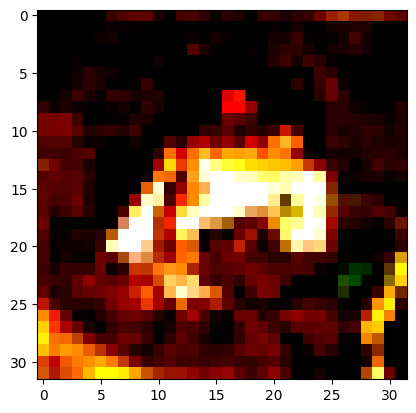

In [10]:
image,label = trainset1[0]
show_image(image, label)

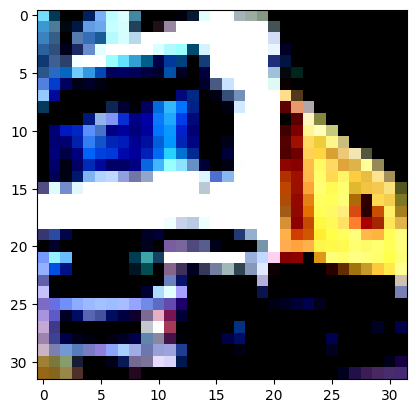

In [11]:
image,label = trainset1[1]
show_image(image, label)

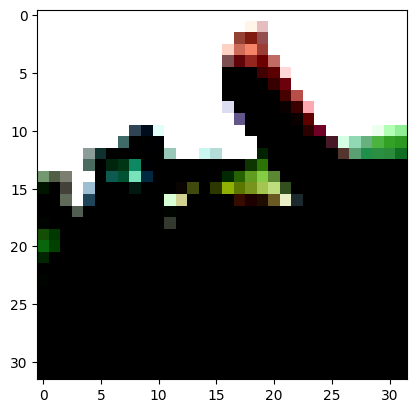

In [12]:
image,label = trainset1[2]
show_image(image, label)

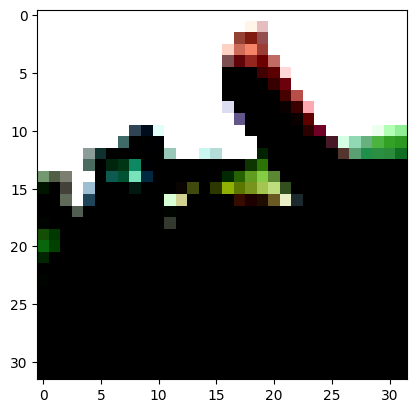

In [13]:
image,label = trainset1[2]
show_image(image, label)

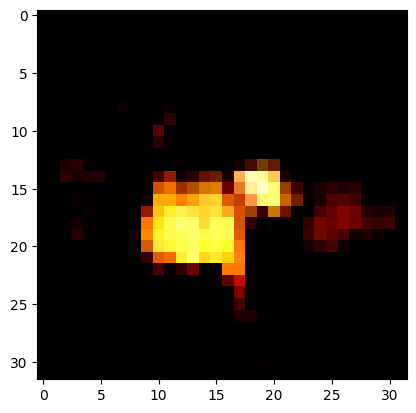

In [14]:
image,label = trainset1[3]
show_image(image, label)

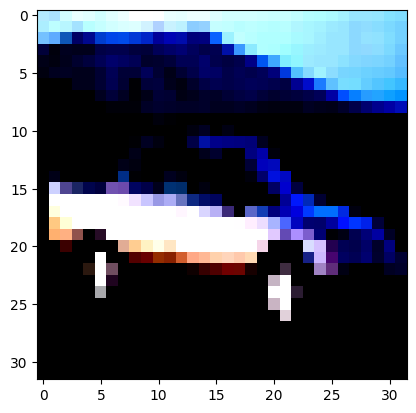

In [15]:
image,label = trainset1[4]
show_image(image, label)

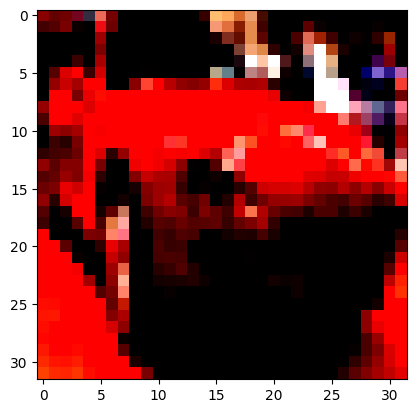

In [16]:
image,label = trainset1[5]
show_image(image, label)

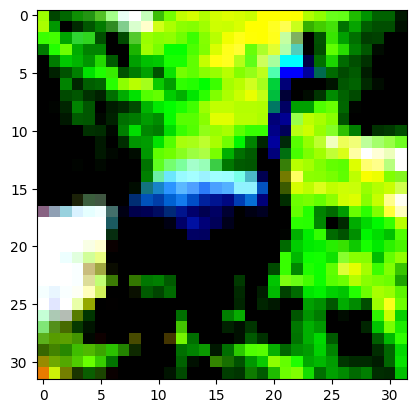

In [17]:
image,label = trainset1[6]
show_image(image, label)

# Define below number of users/clients

In [18]:
users = 5 # clients

In [19]:
trainset1_len = 50000

In [20]:
idxs = np.random.permutation(trainset1_len)
idxs

array([11156, 47671, 12326, ..., 48547, 42906, 25434])

In [21]:
train_indices = idxs
train_indices

array([11156, 47671, 12326, ..., 48547, 42906, 25434])

In [22]:
indices_per_client = int (len(train_indices)/users)

print(indices_per_client)

10000


# trainset2 which has non poisoned data

In [23]:
trainset2 = torchvision.datasets.CIFAR10(root=root_path, download=False, transform=transform)

# TestSet 

In [24]:
testset = torchvision.datasets.CIFAR10 (root=root_path, train=False, download=True, transform=transform)

Files already downloaded and verified


# doing label flipping

In [25]:


# for i in range(len(trainset1)):
#     if (trainset2.targets[i] == 6):
#         trainset2.targets[i] = 8
#     if (trainset2.targets[i] == 2):
#         trainset2.targets[i] = 9

In [26]:
len(testset)

10000

In [27]:
idxs = np.random.permutation(10000)
idxs

array([3361, 2665, 8544, ..., 3159,  870, 8582])

In [28]:
val_indices = idxs
val_indices 

array([3361, 2665, 8544, ..., 3159,  870, 8582])

In [29]:
#experimenting 

users = 5



batch_size = 100

train_loaders2 = [] 

train_trainset2=[]

train_loaders1 = []

train_trainset1 = []


for i in range(users):
  start= indices_per_client*i
  end= indices_per_client * (i+1)
  
  #print((train_indices[start:end]))


  train_trainset1.append(list(train_indices[start:end]))

  train_trainset2.append(list(train_indices[start:end]))

  #print(len(train_dataset))

  train_sampler = SubsetRandomSampler(train_indices[start : end])
  # train_loaders= DataLoader(dataset, batch_size, sampler= train_sampler) 

  #####*********************************************************************################
  ##### IMPORTANT : HERE BELOW CHANGE IF CONDITION TO SELECT NO OF POISONED CLIETNS ########
  #####*********************************************************************################

  if i < 0 :
    print("poisoned: ", i)
    train_loaders1.append(DataLoader(trainset1, batch_size=batch_size,sampler=train_sampler)) # client training on poisoned data
  else:
    train_loaders1.append(DataLoader(trainset2, batch_size=batch_size,sampler=train_sampler)) # rest training on normal data
    print("non-poisoned: ", i)



  train_loaders2.append(DataLoader(trainset2, batch_size=batch_size,sampler=train_sampler))

  





val_sampler = SubsetRandomSampler(val_indices)



test_loader = DataLoader(testset, batch_size=batch_size, sampler=val_sampler) 
# 



non-poisoned:  0
non-poisoned:  1
non-poisoned:  2
non-poisoned:  3
non-poisoned:  4


In [30]:
print(len(train_trainset1))

5


In [31]:
len(train_loaders1)

5

In [32]:
from torch.autograd import Variable
import torch.nn.init as init

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [33]:
net_glob = resnet20()
net_glob.to(device)


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [34]:

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_glob.parameters(), lr=lr, momentum=0.9)


In [35]:
local_epochs = 1

In [36]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [37]:
num_users = 5

frac = 1 # this tells the percentage of clients chosen for each global round. 1=100%(all the clinets are chosen),0.5(only half the clients are chosen)

In [38]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [74]:
# def fgsm_attack(model, loss, images, labels, eps) :
    
#     images = images.to(device)
#     labels = labels.to(device)
#     images.requires_grad = True
           
#     outputs = model(images)
    
#     model.zero_grad()
#     cost = criterion(outputs, labels)
#     cost.backward()
    
#     attack_images = images + eps*images.grad.sign()
#     attack_images = torch.clamp(attack_images, 0, 1)
    
#     return attack_images
def test(net, test_loader, criterion, device, epsilon):
    net.eval()  # set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Generate adversarial examples using FGSM
        data.requires_grad = True
        output = net(data)
        loss = criterion(output, target)
        net.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        #show_image(perturbed_data, target)
        #perturbed_data = perturbed_data.cpu().detach()
        #plt.imshow(perturbed_data.permute(0, 2, 3, 1))
        #perturbed_data = perturbed_data.to(device)
        display_images(perturbed_data.cpu().detach())
        with torch.no_grad():
            output = net(perturbed_data)

        # Compute loss and accuracy
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total

    print("Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
        test_loss, correct, total, accuracy))

In [75]:
def display_images(image):
  #_, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  #image = image.T
  fig, axarr = plt.subplots(2, 2)
  for i in range(2):
      for j in range(2):
          axarr[i, j].imshow(image[i*2+j].permute(1, 2, 0))
  plt.show()

Round1: User3_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 22.23it/s]


client:1 train_acc: 47.75%, train_loss: 28.9073
client:0 train_acc: 47.87%, train_loss: 57.9598
client:4 train_acc: 48.00%, train_loss: 86.4768
client:2 train_acc: 47.97%, train_loss: 115.3927
client:3 train_acc: 47.78%, train_loss: 144.2531


<Figure size 640x480 with 0 Axes>

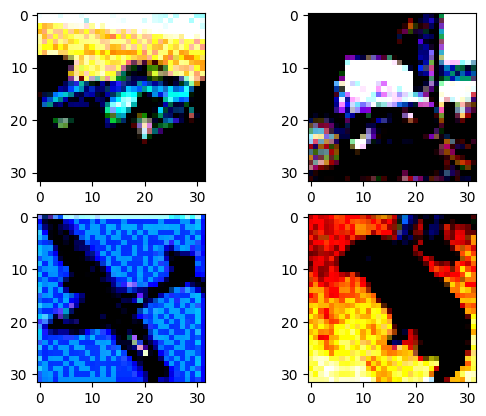

<Figure size 640x480 with 0 Axes>

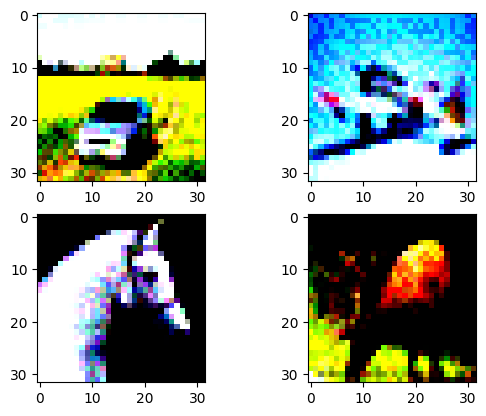

<Figure size 640x480 with 0 Axes>

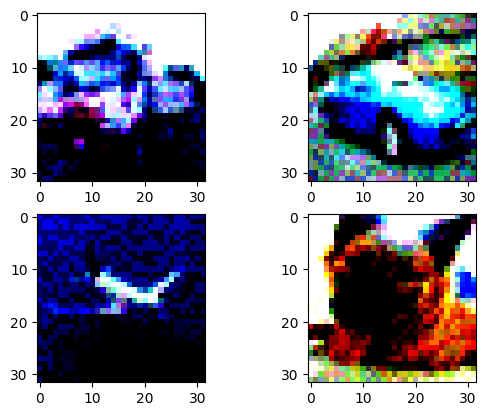

<Figure size 640x480 with 0 Axes>

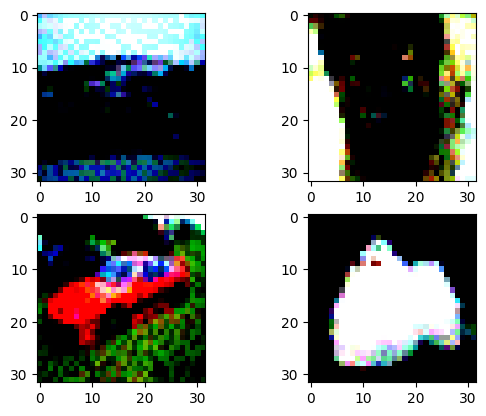

<Figure size 640x480 with 0 Axes>

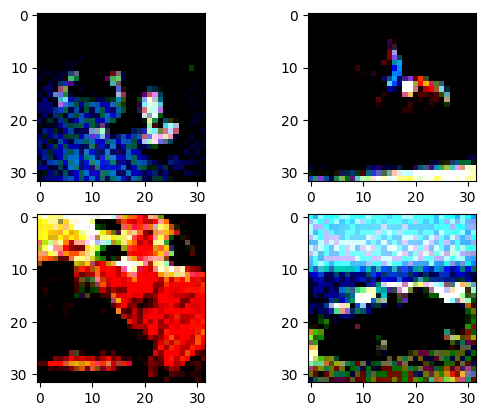

<Figure size 640x480 with 0 Axes>

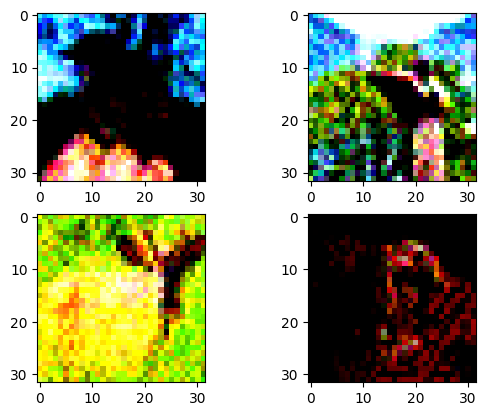

<Figure size 640x480 with 0 Axes>

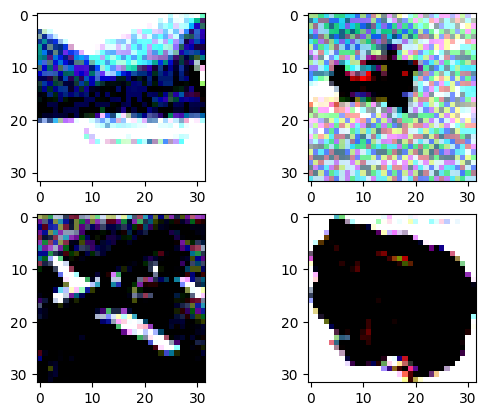

<Figure size 640x480 with 0 Axes>

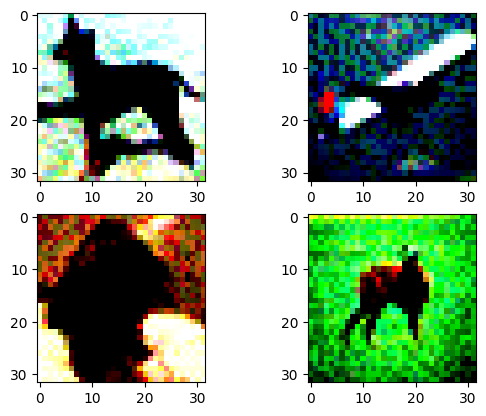

<Figure size 640x480 with 0 Axes>

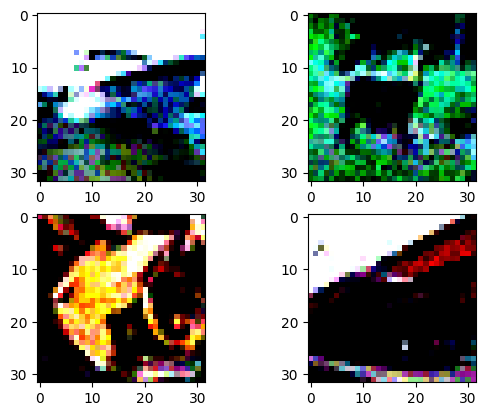

<Figure size 640x480 with 0 Axes>

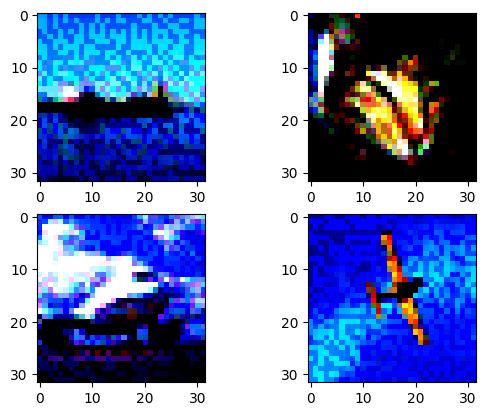

<Figure size 640x480 with 0 Axes>

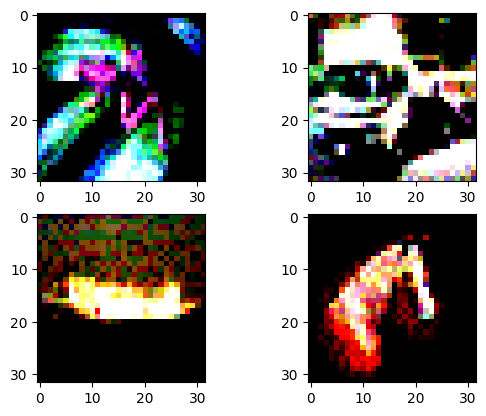

<Figure size 640x480 with 0 Axes>

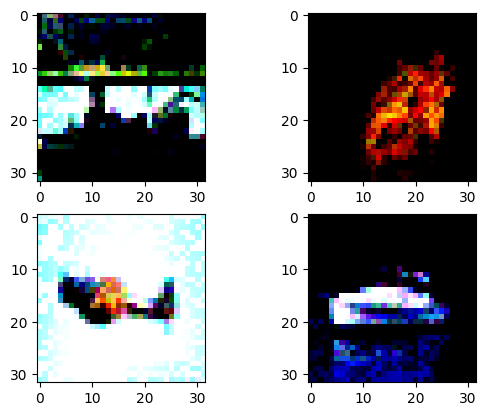

<Figure size 640x480 with 0 Axes>

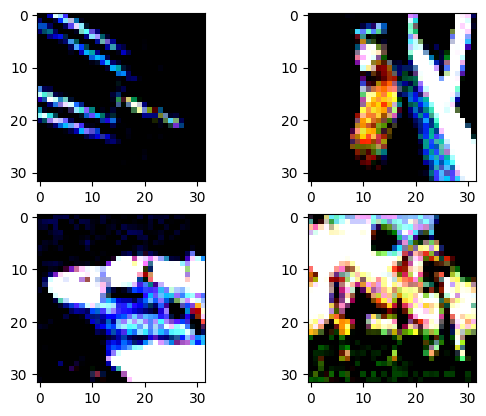

<Figure size 640x480 with 0 Axes>

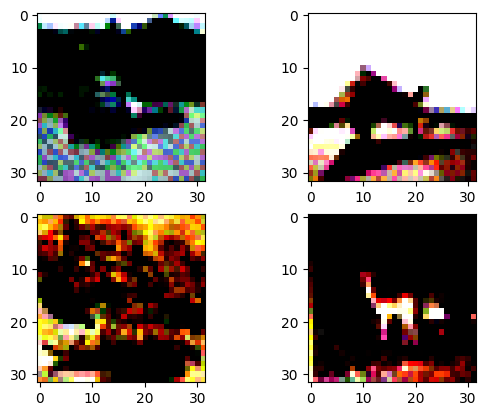

<Figure size 640x480 with 0 Axes>

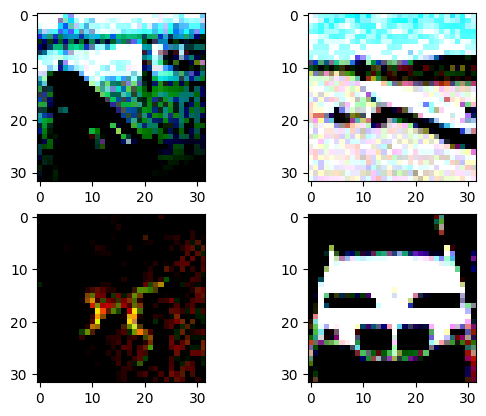

<Figure size 640x480 with 0 Axes>

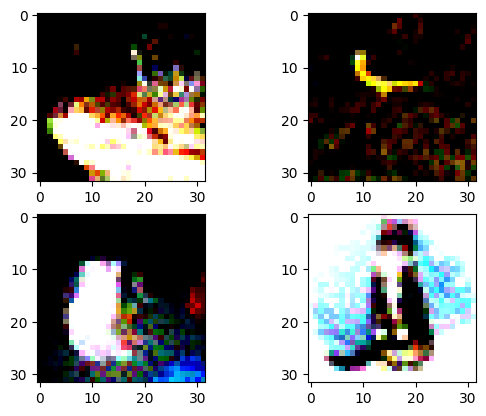

<Figure size 640x480 with 0 Axes>

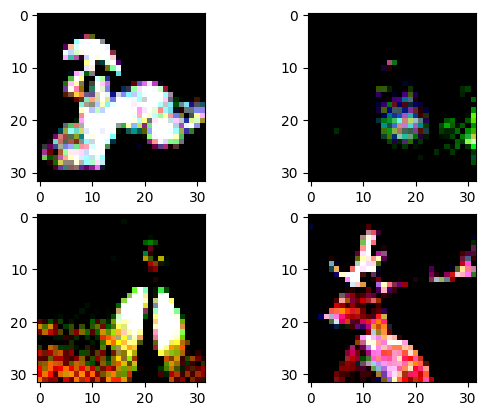

<Figure size 640x480 with 0 Axes>

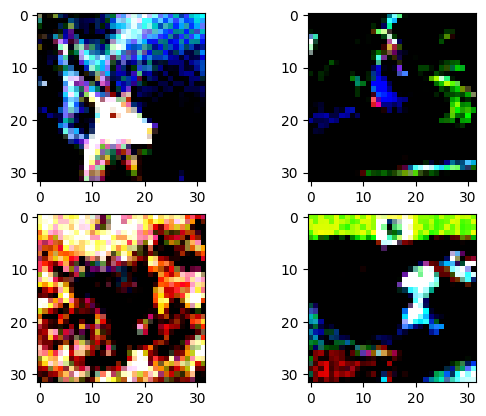

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: ignored

In [77]:
net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

loss_train_collect = []
acc_train_collect = []
loss_test_collect = []
acc_test_collect = []



for iter in range(200):
    w_locals, loss_locals_train, acc_locals_train, loss_locals_test, acc_locals_test = [], [], [], [], []
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace = False)
    

    global_weights = copy.deepcopy(net_glob.state_dict())
   
    # Training/Testing simulation
    for idx in idxs_users: # each client
        
        net_glob.load_state_dict(global_weights)
        # client training local epochs  
        for local_epoch in range(local_epochs):

          for i, data in enumerate(tqdm(train_loaders1[idx], ncols=100, desc='Round'+str(iter+1)+': User'+str(idx)+'_'+str(local_epoch+1))):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #display_images(inputs)
            inputs = inputs.to(device)
            labels = labels.clone().detach().long().to(device)
            #data.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net_glob(inputs)
            loss = criterion(outputs, labels)
            #net_glob.zero_grad()
            loss.backward()
            #data_grad = data.grad.data
            #perturbed_data = fgsm_attack(inputs, 0.3, data_grad)
            #output = net_glob(perturbed_data)
            optimizer.step()
          
        w = copy.deepcopy(net_glob.state_dict())
        w_locals.append(copy.deepcopy(w))
      
      
    w_glob = FedAvg(w_locals)
    # update global model --- copy weight to net_glob -- distributed the model to all users
    net_glob.load_state_dict(w_glob)

    # train acc
    with torch.no_grad():
        corr_num = 0
        total_num = 0
        train_loss = 0.0
        for idx in idxs_users:
          for j, trn in enumerate(train_loaders2[idx]):
            trn_x, trn_label = trn
            trn_x = trn_x.to(device)
            trn_label = trn_label.clone().detach().long().to(device)

            trn_output = net_glob(trn_x)
            loss = criterion(trn_output, trn_label)
            train_loss += loss.item()
            model_label = trn_output.argmax(dim=1)
            corr = trn_label[trn_label == model_label].size(0)
            corr_num += corr
            total_num += trn_label.size(0)
          print("client:{} train_acc: {:.2f}%, train_loss: {:.4f}".format(idx, corr_num / total_num * 100, train_loss / len(train_loaders2)))

    # Assuming you have already defined your neural network model, test dataset loader, loss criterion, and device
    epsilon = 0.2  # choose a value for epsilon
    test(net=net_glob, test_loader=test_loader, criterion=criterion, device=device, epsilon=epsilon)
#     with torch.no_grad():
#         corr_num = 0
#         total_num = 0
#         val_loss = 0.0
#         for j, val in enumerate(test_loader):
#             val_x, val_label = val
#             val_x = val_x.to(device)
#             data = val_x
            
#             data.requires_grad = True
#             #val_x = fgsm_attack(net_glob, loss, val_x, val_label, 0.3).to(device)
#             val_label = val_label.clone().detach().long().to(device)
#             val_output = net_glob(data)
            
#             loss = criterion(val_output, val_label)
#             net_glob.zero_grad()
#             loss.backward()
#             data_grad = data.grad.data
#             perturbed_data = fgsm_attack(data, 0.3, data_grad)
#             output = net_glob(perturbed_data)
#             val_loss += loss.item()
#             model_label = val_output.argmax(dim=1)
#             corr = val_label[val_label == model_label].size(0)
#             corr_num += corr
#             total_num += val_label.size(0)
#             accuracy = corr_num / total_num * 100
#             test_loss = val_loss / len(test_loader)
#         print("test_acc: {:.2f}%, test_loss: {:.4f}".format( accuracy, test_loss))
    
#     # prepare to count predictions for each class
#     correct_pred = {classname: 0 for classname in classes}
#     total_pred = {classname: 0 for classname in classes}

#     # again no gradients needed
#     with torch.no_grad():
#         for data in test_loader:
#             images, labels = data
#             outputs = net_glob(images)
#             _, predictions = torch.max(outputs, 1)
#             # collect the correct predictions for each class
#             for label, prediction in zip(labels, predictions):
#                 if label == prediction:
#                     correct_pred[classes[label]] += 1
#                 total_pred[classes[label]] += 1


#     # print accuracy for each class
#     for classname, correct_count in correct_pred.items():
#         accuracy = 100 * float(correct_count) / total_pred[classname]
#         print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
#                                                       accuracy))



In [ ]:
# Assuming you have already defined your neural network model, test dataset loader, loss criterion, and device
epsilon = 0.3  # choose a value for epsilon
test(net=net_glob, test_loader=test_loader, criterion=criterion, device=device, epsilon=epsilon)


In [ ]:
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net_glob(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                      accuracy))

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)
#from __future__ import absolute_import, division, print_function, unicode_literals

#import os, sys
#from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

In [ ]:
################################# Backdoor_ATTack ###################3
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_dataset('cifar10')

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 30000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [ ]:
y_temp=[]
for i in range(len(y_raw)):
  for j in range(len(y_raw[i])):
    if y_raw[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw=y_temp

In [ ]:
y_temp=[]
for i in range(len(y_raw_test)):
  for j in range(len(y_raw_test[i])):
    if y_raw_test[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw_test=y_temp

In [ ]:
class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

In [ ]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [ ]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    print(x_clean.shape,"x_clean shape")
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]
        print(src_imgs.shape,"src images shape")

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        print(imgs_to_be_poisoned.shape,"imgs to be poisoned shape")
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0
    print(x_poison.shape,"x poison shape")
    return is_poison, x_poison, y_poison

In [ ]:
percent_poison = .1
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
#x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
#x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

c = 9 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays
#c_idx=25
plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
